In [26]:
import os
import sys
import gzip
import shutil

if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import importlib
import matplotlib.pyplot as plt
import numpy as np
import sumolib
import traci
import traci.constants as tc
import pandas as pd

sys.path.append(os.path.abspath("../src"))
from sim import osm_utils
from sim import sumo_utils
from sim import sumo_helper
from sim import sumo_simulation
from sim import llama_connect

FOLDER_NAME = "../src/sumo_map/town05" # Path to SUMO map folder

### Defining paths and setting up osm.sumocfg file

In [2]:
NET_PATH = f'{FOLDER_NAME}/osm.net.xml'
SUMOCFG_PATH = f'{FOLDER_NAME}/osm.sumocfg'
PA_PATH = f'{FOLDER_NAME}/park.add.xml' 
PA_REROUTER_PATH = f'{FOLDER_NAME}/pa_rerouter.xml'

# Setting up time to teleport as 
# -1 (never teleport): Vehicles will never teleport, but this could cause deadlock.
# >0 (seconds): Vehicles will teleport after the specified time if they are not able to reach their destination.
time_to_teleport = 100
sumo_helper.add_xml_child(SUMOCFG_PATH, 'processing', 'time-to-teleport', f'{time_to_teleport}')

# Adding lateral resolution to use SubLane model
lateral_resolution = 0.8
sumo_helper.add_xml_child(SUMOCFG_PATH, 'parameters', 'lateral-resolution', f'{lateral_resolution}')

# Setting up the timestep (default is 1 second), this does not affect the simulation speed but the resolution of the simulation. A smaller timestep will result in a more accurate simulation
step_length = 0.1
sumo_helper.add_xml_child(SUMOCFG_PATH, 'time', 'step-length', f'{step_length}')

# Setting up the simulation duration. To simulate 24 hours, we set the end time to (3600 steps * 24 hours) / step_lenght.
end_time = ''
sumo_helper.add_xml_child(SUMOCFG_PATH, 'time', 'end', f'{end_time}')

if not os.path.exists(NET_PATH):
    gz_path = f"{FOLDER_NAME}/osm.net.xml.gz"
    if os.path.exists(gz_path):
        with gzip.open(gz_path, 'rb') as f_in:
            with open(NET_PATH, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Extracted {gz_path} to {NET_PATH}")
    else:
        raise FileNotFoundError(f"{gz_path} does not exist.")
    
net = sumolib.net.readNet(NET_PATH)
net_offset = net.getLocationOffset() # Necessary to convert from CARLA to SUMO coordinates if needed

Child <time-to-teleport> with value '100' already exists. Skipping addition.
Child <lateral-resolution> with value '0.8' already exists. Skipping addition.
Child <step-length> with value '0.1' already exists. Skipping addition.
Child <end> with value '' already exists. Skipping addition.


# CARLA Routines

This section aims at creating rotines from routes given by CARLA

Here we are loading the interest points we collected in CARLA simulator.

In [5]:
mapname = 'Town05'
routine_points = sumo_helper.get_spawn_points_from_csv(f'{FOLDER_NAME}/interests_spawn_points_{mapname}.csv')
carla_routine_coords = sumo_utils.get_coords_from_spawnpoints(routine_points, net_offset)
carla_routine_coords
sumo_utils.draw_debug_points(carla_routine_coords, output_path=f'{FOLDER_NAME}/debug.add.xml', size=5) # Write debug points to file to visualize in the spawn points in SUMO

Here we are loading the routines we obtained using the LLM. They are the routines generated by the carla simulator and are stored at `src/sim`.

In [7]:
routines = sumo_helper.get_routines_from_csv(f'../src/sim/llm_routines')
routines[0]

{'7': {'location': 'home', 'activity': 'wake up'},
 '8': {'location': 'school', 'activity': 'work'},
 '9': {'location': 'work', 'activity': 'office work'},
 '10': {'location': 'home', 'activity': 'break'},
 '11': {'location': 'gym', 'activity': 'workout'},
 '12': {'location': 'home', 'activity': 'lunch'},
 '13': {'location': 'university', 'activity': 'study'},
 '14': {'location': 'gym', 'activity': 'workout'},
 '15': {'location': 'cafe', 'activity': 'snack'},
 '16': {'location': 'theater', 'activity': 'watch movie'},
 '17': {'location': 'home', 'activity': 'collect kids'},
 '18': {'location': 'school', 'activity': 'pick up kids'},
 '19': {'location': 'bar', 'activity': 'relax'},
 '20': {'location': 'home', 'activity': 'spend time with family'},
 '21': {'location': 'gym', 'activity': 'evening workout'},
 '22': {'location': 'home', 'activity': 'dinner'},
 '23': {'location': 'home', 'activity': 'sleep'}}

From each routine, we transform it into coords of a SUMO trip

In [8]:
# This is the location time list from the routine generated in CARLA
location_time_list_carla = []
routine_ids_carla = []

departure_times_carla = [0] * len(routines)
for i in range(len(routines)):
    routine_ids_carla.append(f"veh{i}")
    location_time_list_carla.append(sumo_utils.coords_to_trip(routines[i], carla_routine_coords))

location_time_list_carla[0]

{7: {'location': 'home',
  'coords': (230.31962997436523, 306.0381248474121),
  'name': 'home'},
 8: {'location': 'school',
  'coords': (295.3574984741211, 175.5333984375),
  'name': 'school'},
 9: {'location': 'work',
  'coords': (230.31962997436523, 306.0381248474121),
  'name': 'work'},
 11: {'location': 'gym',
  'coords': (145.03018981933593, 82.74409179687501),
  'name': 'gym'},
 12: {'location': 'home',
  'coords': (230.31962997436523, 306.0381248474121),
  'name': 'home'},
 13: {'location': 'university',
  'coords': (173.02686149597167, 149.8197982788086),
  'name': 'university'},
 14: {'location': 'gym',
  'coords': (145.03018981933593, 82.74409179687501),
  'name': 'gym'},
 15: {'location': 'cafe',
  'coords': (104.77784759521484, 314.62861328125),
  'name': 'cafe'},
 16: {'location': 'theater',
  'coords': (12.46317321777343, 328.9825866699219),
  'name': 'theater'},
 17: {'location': 'home',
  'coords': (230.31962997436523, 306.0381248474121),
  'name': 'home'},
 18: {'locat

In [9]:
location_time_list = location_time_list_carla
routine_ids = routine_ids_carla
departure_times = departure_times_carla

First we get interval of parameters from the LLM for each driving style

Now we will generate the parameters for each style. The csv file `DriverBehParameters` must contain the relevant parameters, ranges and descriptions.

In [15]:
styles = ["normal", "aggressive"] # Description of the styles of the vehicles that are going to be generated
data = pd.read_csv('../src/sim/DriverBehParameters.csv')
params = sumo_helper.csv_str(data) # Turns the csv file into a string that can be passed to the LLM

param_dict = llama_connect.get_range_parameters(data, params, styles) # Generates the parameters for the vehicles
llama_connect.verify_parameters(param_dict, styles, separate_distributions=True)

minGap of aggressive is contained inside normal
Verifying startupDelay for normal: {'explanation': 'normal drivers start driving immediately after stopping', 'min': 0, 'max': 1}
tau of aggressive is contained inside normal
taccmax of aggressive is contained inside normal
lcCooperative of aggressive is contained inside normal
lcKeepRight of aggressive is contained inside normal
lcSpeedGainLookahead of aggressive is contained inside normal
Verifying lcOvertakeDeltaSpeedFactor for normal: {'explanation': 'normal drivers do not overtake aggressively', 'min': 0, 'max': 0.5}
lcTimeToImpatience of aggressive is contained inside normal
lcLaneDiscipline of aggressive is contained inside normal
Verifying startupDelay for aggressive: {'explanation': 'aggressive drivers start driving quickly after stopping', 'min': 1, 'max': 1.5}
Verifying lcOvertakeDeltaSpeedFactor for aggressive: {'explanation': 'aggressive drivers overtake aggressively', 'min': 0.5, 'max': 1}
Expected mean speed: 5.0, max speed

In [13]:
param_dict['lcOvertakeDeltaSpeedFactor']

{'normal': {'explanation': 'normal drivers do not prioritize overtaking',
  'min': 0.1,
  'max': 0.2},
 'aggressive': {'explanation': 'aggressive drivers prioritize overtaking',
  'min': 0.5,
  'max': 0.9}}

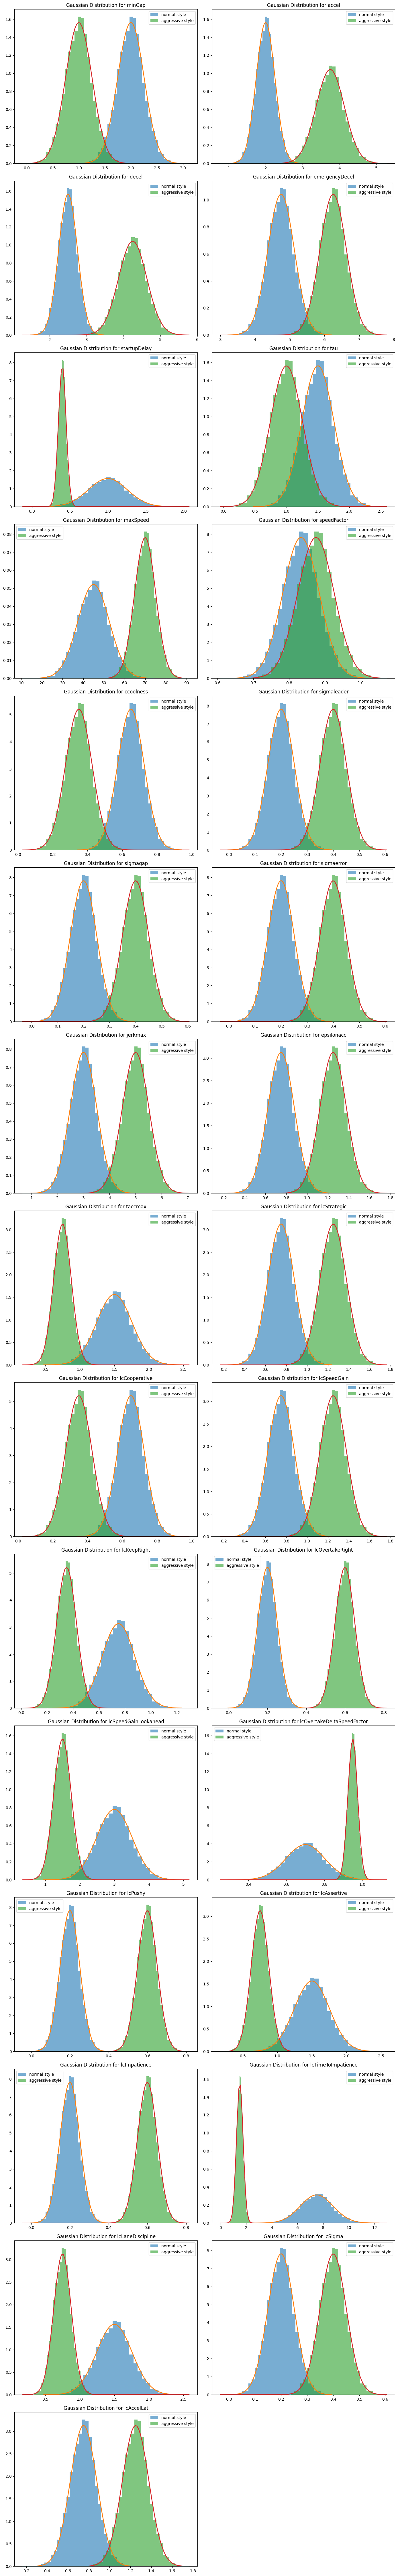

In [32]:
# Plot the distribution of the parameters for verification
sumo_utils.show_gaussians(param_dict, [data['Parameter'][i] for i in range(len(data['Parameter']))], styles) 

Now we create the distributions files vTypesDistribution.xml containing n_vtypes possible parameters for a given driving style. Here we define the car-following model and the lane-chaning model of the vehicles as well

In [16]:
n_vtypes = 5 # Number of vehicles with varied parameters for each style
vehdists = sumo_utils.generate_vehicle_types(param_dict, styles, n_vtypes) # Generates the vehicle types for the vehicles
sumo_helper.parse_veh_dist_xml(param_dict, vehdists, styles, f'{FOLDER_NAME}/vTypesDistribution.xml', car_follow_model="EIDM", lc_model="SL2015") # Parses the vehicles to the XML format and writes it to vTypesDistribution.xml
vtype_data = sumo_helper.extract_vtype_distribution(f"{FOLDER_NAME}/vTypesDistribution.xml")
vtype_data

{'normal': ['v_normal0', 'v_normal1', 'v_normal2', 'v_normal3', 'v_normal4'],
 'aggressive': ['v_aggressive0',
  'v_aggressive1',
  'v_aggressive2',
  'v_aggressive3',
  'v_aggressive4']}

## Creating Routine Trips

Defining the veh_style for each routine driver and creating the XML file for them, this will be written to **finaltrips.rou.xml** and this file can be used directly as a route file for SUMO if there is no need to generate random trips.

In [17]:
# Merging the trips generated by the LLM with the random trips
final_trips_file_name = "finaltrips.rou.xml"
final_trips_path = f'{FOLDER_NAME}/{final_trips_file_name}'

veh_style_per_student = []
for i in range(len(location_time_list)):
    if i % 2:
        # If the index is odd, use the random trip id
        veh_style_per_student.append(np.random.choice(vtype_data['normal'])) # Randomly choose a vehicle type from the normal distribution
    else:
        veh_style_per_student.append(np.random.choice(vtype_data['aggressive'])) # Randomly choose a vehicle type from the normal distribution

steps_per_stop = 10 # Number of steps in an hour

for i in range(len(location_time_list)):
    path, stop_durations = sumo_utils.get_path(location_time_list[i], net, steps_per_stop=steps_per_stop, use_carla_routine=True) # Get the path and stop durations for the trips
    sumo_helper.parse_trip_xml(path, stop_durations, len(location_time_list), departure_times, veh_style_per_student, use_carla_routine=True, veh_ids=routine_ids, out_file_path=f'{FOLDER_NAME}/{final_trips_file_name}')

sumo_helper.add_missing_vtypes(final_trips_path, f"{FOLDER_NAME}/vTypesDistribution.xml", final_trips_path) # Adds the missing vehicle types to the final trips file

Updated ROUTES_FILE saved as ../src/sumo_map/town05/finaltrips.rou.xml


True

### Creating Random Trips to fill the simulation

Now we generate random vehicles throughout the simulation that will depart at each departure_step. Notice that they will not be running during all the simulation. The result will be written to **randtrips.rou.xml** and this file can be used as a route-file for SUMO directly if only random trips are desired.

In [18]:
# Generates equally distributed random trips for each vehicle class
# The trips will be written to the file "randtrips.rou.xml" and the vehicle ids will be returned 
rand_trips_file_name = "randtrips.rou.xml"
rand_trips_path = f'{FOLDER_NAME}/{rand_trips_file_name}'
end_time = 2000 # Overwrite the end time to 2000 seconds, the average time of the routines
random_trips_ids = sumo_utils.get_random_trips(NET_PATH, end_time, vtype_data, departure_step=10, output_file_path=f'{FOLDER_NAME}/{rand_trips_file_name}')
sumo_helper.add_missing_vtypes(rand_trips_path, f"{FOLDER_NAME}/vTypesDistribution.xml", rand_trips_path) # Adds the missing vehicle types to the random trips file
print(random_trips_ids)

Success.
Success.
Generated 200 vehicles.
Updated ROUTES_FILE saved as ../src/sumo_map/town05/randtrips.rou.xml
{'normal': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'], 'aggressive': ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138

### Merging the trips and updating route files

Lastly, merging the file with the routines and the file with the random trips into the **merged.rou.alt.xml** file.

In [19]:
output_file_name = "merged.rou.xml"
output_file_path = f'{FOLDER_NAME}/{output_file_name}'

sumo_helper.make_output_file(output_file_path, final_trips_file_path = final_trips_path, random_trips_file_path = rand_trips_path)

Output file created at ../src/sumo_map/town05/merged.rou.xml


'../src/sumo_map/town05/merged.rou.xml'

Changing the sumocfg file to use the new files created

In [20]:
# Changing sumocfg to use the new route file
sumo_helper.add_xml_child(SUMOCFG_PATH, 'input', 'route-files', output_file_name)

if os.path.exists(f'{FOLDER_NAME}/debug.add.xml'):
    sumo_helper.add_xml_child(SUMOCFG_PATH, 'input', 'additional-files', 'debug.add.xml', replace=False)

print("All done! The SUMO configuration file has been updated to use the new route file.")
print(f"You can now run the simulation inside the {FOLDER_NAME} folder using `sumo-gui osm.sumocfg` or generate the data using the Simulation Data section.")

Child <route-files> with value 'merged.rou.xml' already exists. Skipping addition.
Child <additional-files> with value 'debug.add.xml' already exists. Skipping addition.
All done! The SUMO configuration file has been updated to use the new route file.
You can now run the simulation inside the ../src/sumo_map/town05 folder using `sumo-gui osm.sumocfg` or generate the data using the Simulation Data section.


In [21]:
try:
    print("IDs for the vehicles that were generated with routines:")
    print(routine_ids)
except:
    print("No vehicles were generated with routines.")

try:
    print("IDs for the vehicles that were generated with random trips:")
    print(random_trips_ids)
except:
    print("No vehicles were generated with random trips.")

IDs for the vehicles that were generated with routines:
['veh0']
IDs for the vehicles that were generated with random trips:
{'normal': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'], 'aggressive': ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136'

In [25]:
# Save the routines of each vehicle in a CSV file
try:
    sumo_helper.save_routines_csv(location_time_list, routine_ids, dir_path = f'{FOLDER_NAME}/routines', use_lat_lon = False)
except Exception as e:
    print(f"Error saving routines (were they generated?): \n{e}")


Route saved to: ../src/sumo_map/town05/routines/veh0.csv


## Simulation Data

In [ ]:
output_data_path = "../data/synthetic/sumo/config_a"
experiment2_file = 'merged.rou.xml' # The file that contains the routes for the experiment
delta_time = 0.01 # This delta time has to be the same as the one used in CARLA
end_time = 0 # 0 means no end time, the simulation will run until all vehicles finish their route

if os.path.exists(output_data_path):
    shutil.rmtree(output_data_path)
os.makedirs(output_data_path, exist_ok=True)

sumo_helper.add_xml_child(f'{FOLDER_NAME}/osm.sumocfg', 'input', 'route-files', f'{experiment2_file}', replace=True)

Child <route-files> with value 'merged.rou.xml' already exists. Skipping addition.


False

In [ ]:
try:
    veh_variables = sumo_simulation.get_all_variables(FOLDER_NAME, routine_ids, delta_time=delta_time, end_hours=end_time, use_gui=False, convert_geo=False, freeze_traffic_lights=True) # Running the simulation
    
except KeyboardInterrupt as e:
    traci.close() # Close the simulation if there is an error
    print(f"An error occurred: {e}")

In [35]:
filesnames = {}
for i in range(len(routine_ids)):
    filesnames[routine_ids[i]] = f'{routine_ids[i]}_{veh_style_per_student[i].split("_")[-1]}'

sumo_simulation.save_data(veh_variables, output_data_path, delta_time, file_names=filesnames, new_dir=True, verify=True, use_lat_lon=False)

In [37]:
files = os.listdir(output_data_path)
df = pd.read_csv(f'{output_data_path}/{files[0]}')

In [38]:
def plot_df(df):
    fig, axs = plt.subplots(1, 3, figsize=(25, 5))

    # Plot acc_x
    axs[0].plot(df['timestamp'], df['acc_x'], label='acc_x')
    axs[0].set_title('Acceleration X over Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('acc_x (m/s²)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot acc_y
    axs[1].plot(df['timestamp'], df['acc_y'], label='acc_y', color='orange')
    axs[1].set_title('Acceleration Y over Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('acc_y (m/s²)')
    axs[1].legend()
    axs[1].grid(True)
    
    # Plot x_pos vs y_pos, colored by time
    sc = axs[2].scatter(df['x_pos'], df['y_pos'], c=df['timestamp'], cmap='viridis', label='Trajectory')
    axs[2].set_title('Trajectory: x_pos vs y_pos (colored by time)')
    axs[2].set_xlabel('x_pos')
    axs[2].set_ylabel('y_pos')
    axs[2].legend()
    axs[2].grid(True)
    cbar = plt.colorbar(sc, ax=axs[2])
    cbar.set_label('Time (s)')

    plt.tight_layout()
    plt.show()

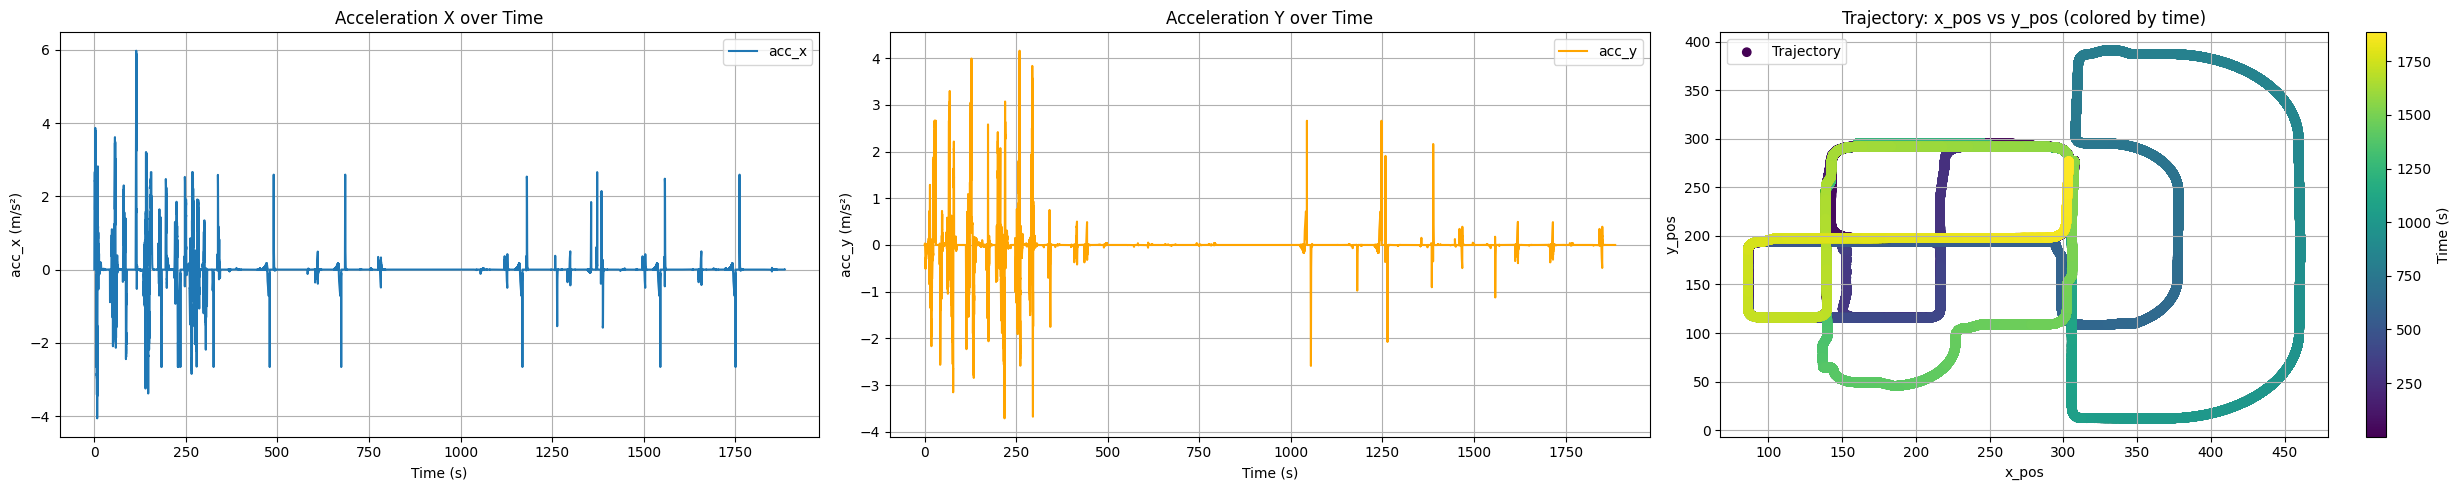

In [39]:
plot_df(df)